In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import KFold, GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

random_seed = 2024
best_params = {}

param_grid = {
    'RF': {'n_estimators': [50, 75, 100, 200, 300, 400], 'max_depth': [None, 5, 10, 15, 20]},
    'GB': {'n_estimators': [50, 75, 100, 200, 300, 400], 'max_depth': [None, 5, 10, 15, 20]},
    'KNN': {'n_neighbors': [5, 10, 15], 'leaf_size': [25, 30, 35]},
    'DT': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 4, 6]},
    'SVR': {'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto', 0.1, 1, 10]},
    'KRR': {'gamma': [None, 0.01, 0.001, 0.0001]},
    'BG': {'n_estimators': [50, 75, 100, 200, 300, 400]},
    'ET': {'n_estimators': [50, 75, 100, 200, 300, 400], 'max_depth': [None, 5, 10, 15, 20]}
}

models = {
    "RF": RandomForestRegressor(n_jobs=-1, random_state=random_seed),
    "GB": GradientBoostingRegressor(random_state=random_seed),
    "KNN": KNeighborsRegressor(n_jobs=-1),
    "DT": DecisionTreeRegressor(random_state=random_seed),
    "SVR": SVR(),
    "KRR": KernelRidge(),
    "BG": BaggingRegressor(n_jobs=-1, random_state=random_seed),
    "ET": ExtraTreesRegressor(n_jobs=-1, random_state=random_seed),
}

kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)

directory = "."

datasets = {
    'rdkit-II': 'rdkit-II.npz',

}
test_index = [87, 381, 316, 120, 479, 448, 197, 507, 198, 379, 508, 313, 265, 449, 453, 89, 292, 88, 121, 266, 454, 455, 447, 456, 271, 
              269, 294, 293, 297, 248, 249, 464, 312, 499, 289, 509, 511, 267, 166, 386, 290, 392, 498, 91, 488, 7, 278, 54, 285, 94, 303, 
              358, 444, 5, 286, 98, 458, 2, 291, 268, 470, 262, 308, 272, 53, 354, 512, 360, 495, 468, 391, 310, 307, 457, 306, 258, 352, 
              305, 357, 131, 362, 42, 311, 460, 304, 510, 298, 263, 350, 368, 100, 115, 61, 500, 56, 90, 442, 277, 487, 309, 0, 1, 356]

External_index = [462,119 ,396, 273, 375, 503, 318, 504, 472, 463, 465, 341, 342, 340, 477, 327, 348, 476,423 ,377, 332, 333, 182, 181,
                  349, 183, 112, 328, 323, 324, 113, 329, 330, 331, 144, 145,149, 150, 153, 151, 152, 154, 147, 485, 148, 482, 370, 373,
                  372, 146, 371]

for desc_name, file_path in datasets.items():
    full_path = os.path.join(directory, file_path)
    if os.path.exists(full_path):
        with np.load(full_path, allow_pickle=True) as npz_file:
            array_data = npz_file['data']
            columns = npz_file['columns']
            df = pd.DataFrame(array_data, columns=columns)

            length_db = len(df) // 2
            
            test_index_db2 = [i + length_db for i in test_index]
            External_index_db2 = [i + length_db for i in External_index]
            all_indices = set(range(len(df)))  
            train_val_indices = sorted(list(all_indices - set(test_index) - set(test_index_db2) - set(External_index) - set(External_index_db2))) 

            X = df.drop(columns=['YRed/Ox', 'compound_name'])
            y = df['YRed/Ox']

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X.iloc[train_val_indices])
            y_train_val = y.iloc[train_val_indices]

            for model_name, model in models.items():
                if model_name in param_grid:
                    GS = GridSearchCV(model, param_grid[model_name], cv=kfold, n_jobs=-1, scoring='r2')
                    GS.fit(X_scaled, y_train_val)
                    best_score = GS.best_score_
                    best_param = GS.best_params_
                    best_params[(model_name, desc_name)] = best_param
                    print(f"Dataset: {desc_name}, Model: {model_name}, Best Score: {best_score:.4f}, Best Params: {best_param}")


Dataset: rdkit-II, Model: RF, Best Score: 0.9516, Best Params: {'max_depth': 10, 'n_estimators': 100}
Dataset: rdkit-II, Model: GB, Best Score: 0.9537, Best Params: {'max_depth': 5, 'n_estimators': 100}
Dataset: rdkit-II, Model: KNN, Best Score: 0.7743, Best Params: {'leaf_size': 25, 'n_neighbors': 15}
Dataset: rdkit-II, Model: DT, Best Score: 0.9207, Best Params: {'max_depth': 20, 'min_samples_split': 6}
Dataset: rdkit-II, Model: SVR, Best Score: 0.9145, Best Params: {'gamma': 'scale', 'kernel': 'linear'}
Dataset: rdkit-II, Model: KRR, Best Score: -27.1019, Best Params: {'gamma': None}
Dataset: rdkit-II, Model: BG, Best Score: 0.9520, Best Params: {'n_estimators': 75}
Dataset: rdkit-II, Model: ET, Best Score: 0.9539, Best Params: {'max_depth': 20, 'n_estimators': 400}


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from itertools import product

params = {'n_estimators': [50,75,100,200,300,400],'max_depth': [None, 5, 10, 15, 20]}

for desc_name, file_path in datasets.items():
    full_path = os.path.join(directory, file_path)
    if os.path.exists(full_path):
        with np.load(full_path, allow_pickle=True) as npz_file:
            data = npz_file['data']
            columns = npz_file['columns']
            df = pd.DataFrame(data, columns=columns)

            length_db = len(df) // 2
            
            test_index_db2 = [i + length_db for i in test_index]
            External_index_db2 = [i + length_db for i in External_index]
            all_indices = set(range(len(df)))  
            train_val_indices = sorted(list(all_indices - set(test_index) - set(test_index_db2) - set(External_index) - set(External_index_db2)))  

            X = df.drop(columns=['YRed/Ox', 'compound_name'])
            y = df['YRed/Ox']

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X.iloc[train_val_indices])
            y_train_val = y.iloc[train_val_indices]
            result = []

            for n_estimators, max_depth in product(params['n_estimators'], params['max_depth']):
                model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=random_seed)
                all_test_p = []
                all_test_y = []
                for train_idx, test_idx in kfold.split(X_scaled, y_train_val):
                    train_x, test_x = X_scaled[train_idx], X_scaled[test_idx]
                    train_y, test_y = y_train_val.iloc[train_idx], y_train_val.iloc[test_idx]
                    model.fit(train_x, train_y)
                    all_test_p.append(model.predict(test_x))
                    all_test_y.append(test_y)
                all_test_p = np.concatenate(all_test_p,axis=0)
                all_test_y = np.concatenate(all_test_y,axis=0)
                mae = mean_absolute_error(all_test_y,all_test_p)
                r2 = r2_score(all_test_y,all_test_p)
                result.append([n_estimators,max_depth,mae,r2])
                
            best_result = sorted(result,key=lambda x: x[3], reverse=True)[0]
            best_param = {'n_estimators':best_result[0],'max_depth':best_result[1]}
            best_params[('XGB', desc_name)] = best_param
            print(f'Model: XGB, Dataset: {desc_name}, Best R2 Score: {best_result[3]:.4f}, Best Param: {best_param}')

Model: XGB, Dataset: rdkit-II, Best R2 Score: 0.9492, Best Param: {'n_estimators': 100, 'max_depth': None}


In [5]:
best_params

{('RF', 'rdkit-II'): {'max_depth': 10, 'n_estimators': 100},
 ('GB', 'rdkit-II'): {'max_depth': 5, 'n_estimators': 100},
 ('KNN', 'rdkit-II'): {'leaf_size': 25, 'n_neighbors': 15},
 ('DT', 'rdkit-II'): {'max_depth': 20, 'min_samples_split': 6},
 ('SVR', 'rdkit-II'): {'gamma': 'scale', 'kernel': 'linear'},
 ('KRR', 'rdkit-II'): {'gamma': None},
 ('BG', 'rdkit-II'): {'n_estimators': 75},
 ('ET', 'rdkit-II'): {'max_depth': 20, 'n_estimators': 400},
 ('XGB', 'rdkit-II'): {'n_estimators': 100, 'max_depth': None}}

In [6]:
np.save('./hyperparameters_opt.npy',best_params)

In [7]:
best_params = np.load('./hyperparameters_opt.npy',allow_pickle=True).item()

In [8]:
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from scipy.stats import pearsonr
from sklearn.feature_selection import RFECV
import seaborn as sns
import matplotlib.pyplot as plt
import inspect 

def initialize_model(model_name, custom_params=None, random_state=None):
    """
    Initialize various regression models with optional custom parameters and random state.
    
    Args:
    model_name (str): The name of the model to initialize.
    custom_params (dict, optional): Custom parameters for the model.
    random_state (int, optional): Random seed for reproducibility, defaults to None.

    Returns:
    model: Initialized model object.
    """
    model_defaults = {
        'RF': RandomForestRegressor,
        'GB': GradientBoostingRegressor,
        'KNN': KNeighborsRegressor,
        'DT': DecisionTreeRegressor,
        'SVR': SVR,
        'BG': BaggingRegressor,
        'ET': ExtraTreesRegressor,
        'BR': BayesianRidge,
        'Ridge': Ridge,
        'XGB': XGBRegressor
    }

    model_class = model_defaults.get(model_name)
    if not model_class:
        raise ValueError(f"{model_name} is not a valid model name.")

    # Prepare parameters to initialize the model
    params = custom_params if custom_params else {}
    if 'random_state' in inspect.signature(model_class).parameters:
        params['random_state'] = random_state

    # Initialize and return the model
    return model_class(**params)


In [9]:
model_names = ['RF', 'GB', 'KNN', 'DT', 'SVR', 'BG', 'ET', 'BR',  'Ridge',  'XGB']
kfold = KFold(n_splits=10,shuffle=True,random_state=random_seed)
performance_result = {}

for model_name in model_names:
    model_params = best_params.get(model_name)

    model = initialize_model(model_name, model_params,random_state=random_seed)
    for desc_name, file_path in datasets.items():
        full_path = os.path.join(directory, file_path)
        if os.path.exists(full_path):
            with np.load(full_path, allow_pickle=True) as npz_file:
                data = npz_file['data']
                columns = npz_file['columns']
                df = pd.DataFrame(data, columns=columns)

                length_db = len(df) // 2
            
                test_index_db2 = [i + length_db for i in test_index]
                External_index_db2 = [i + length_db for i in External_index]
                all_indices = set(range(len(df)))  
                train_val_indices = sorted(list(all_indices - set(test_index) - set(test_index_db2) - set(External_index) - set(External_index_db2)))  

                X, y = df.drop(columns=['YRed/Ox', 'compound_name']), df['YRed/Ox']

                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X.iloc[train_val_indices])
                y_train_val = y.iloc[train_val_indices]
                all_test_p = []
                all_test_y = []
                for train_idx, test_idx in kfold.split(X_scaled, y_train_val):
                    train_x, test_x = X_scaled[train_idx], X_scaled[test_idx]
                    train_y, test_y = y_train_val.iloc[train_idx], y_train_val.iloc[test_idx]
                    test_P = []
                    for try_ in range(10): 
                        model.fit(train_x,train_y)
                        test_p = model.predict(test_x)
                        test_P.append(test_p)
                    test_p = np.mean(test_P,axis=0)
                    all_test_p.append(test_p)
                    all_test_y.append(test_y)
                all_test_p = np.concatenate(all_test_p)
                all_test_y = np.concatenate(all_test_y)
                mae = mean_absolute_error(all_test_y,all_test_p)
                r2 = r2_score(all_test_y,all_test_p)
                pearson_r,_ = pearsonr(all_test_y,all_test_p)
                performance_result[(model_name,desc_name)] = [mae,r2,pearson_r,all_test_y,all_test_p]
                print('Model: %4s, Desc: %4s, R2: %.4f, PearsonR: %.4f, MAE: %.4f'%(model_name,desc_name,r2,pearson_r,mae))


Model:   RF, Desc: rdkit-II, R2: 0.9522, PearsonR: 0.9759, MAE: 0.1381
Model:   GB, Desc: rdkit-II, R2: 0.9517, PearsonR: 0.9756, MAE: 0.1422
Model:  KNN, Desc: rdkit-II, R2: 0.7360, PearsonR: 0.8595, MAE: 0.3341
Model:   DT, Desc: rdkit-II, R2: 0.9196, PearsonR: 0.9594, MAE: 0.1820
Model:  SVR, Desc: rdkit-II, R2: 0.8108, PearsonR: 0.9006, MAE: 0.2601
Model:   BG, Desc: rdkit-II, R2: 0.9483, PearsonR: 0.9738, MAE: 0.1490
Model:   ET, Desc: rdkit-II, R2: 0.9543, PearsonR: 0.9769, MAE: 0.1343
Model:   BR, Desc: rdkit-II, R2: 0.9390, PearsonR: 0.9691, MAE: 0.1651
Model: Ridge, Desc: rdkit-II, R2: 0.9267, PearsonR: 0.9631, MAE: 0.1743
Model:  XGB, Desc: rdkit-II, R2: 0.9492, PearsonR: 0.9743, MAE: 0.1443


In [10]:
np.save('./models_descs_screening_10_fold_new.npy',performance_result)

In [11]:
performance_result = np.load('./models_descs_screening_10_fold_new.npy',allow_pickle=True).item()

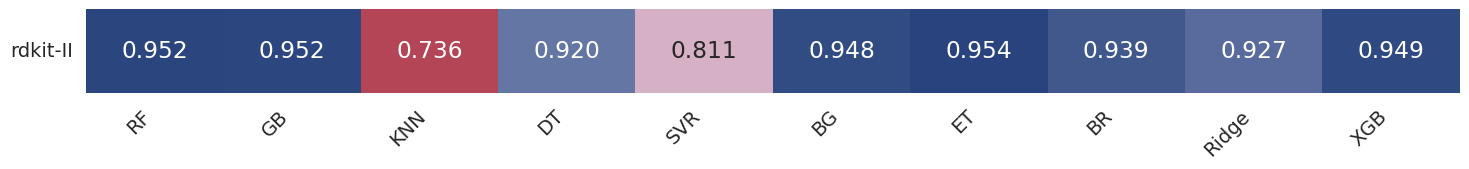

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

model_names = ['RF', 'GB', 'KNN', 'DT', 'SVR', 'BG', 'ET', 'BR',  'Ridge',  'XGB']
desc_names = list(datasets.keys())
r2_map = np.zeros((len(desc_names), len(model_names)))
r2_min_value = 0

for i, m in enumerate(model_names):
    for j, d in enumerate(desc_names):
        r2_map[j, i] = max(performance_result[(m,d)][1], r2_min_value)
colors = ["#b34557", "#e7e4f8", "#28437d"] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
fig, ax = plt.subplots(figsize=(15, 2)) 
sns.set(font_scale=1.4)  
sns.heatmap(r2_map, annot=True, fmt='.3f', xticklabels=model_names, yticklabels=desc_names, cmap=cmap, cbar=False, ax=ax)
plt.xticks(rotation=45, ha='right', fontsize=14)  
plt.yticks(rotation=0, fontsize=14)             
plt.tight_layout()
plt.savefig('./heatmap-rdkit-II.tif', dpi=600)  
plt.savefig('./heatmap-rdkit-II.png', dpi=600)
plt.show()